# This notebook contains the code to reproduce Figures 2 and A.2 in the paper

#### You might also want to refer to the [folktables](https://github.com/zykls/folktables) documentation

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import sklearn

from sklearn.model_selection import train_test_split

import shap
import lime

from folktables import ACSDataSource, ACSIncome

import facct_util as futil

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the dataset

In [3]:
data_source = ACSDataSource(survey_year='2016', horizon='1-Year', survey='person')

data = data_source.get_data(states=["CA"], download=True)
features, labels, _ = ACSIncome.df_to_numpy(data)

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

features = ACSIncome.features
cts_features = ['AGEP', 'WKHP']

# We did not find 'RELP' in the documentation of the dataset. It has <17 values so treat it as categorical
categorical_features = ['COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX', 'RAC1P'] 

len(features), len(cts_features), len(categorical_features)

(10, 2, 8)

## Train a gradient boosted tree

In [4]:
import xgboost
gbtree = xgboost.XGBClassifier(n_estimators=300, max_depth=5, use_label_encoder=False, random_state=0)
gbtree.fit(X_train, Y_train)
sklearn.metrics.accuracy_score(Y_test, gbtree.predict(X_test))

[13:07:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8321152531678847

## Explanation Algorithms

In [5]:
from collections import defaultdict

categorical_feature_indices = [i for i, e in enumerate(features) if e in categorical_features]

# LIME
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, 
                                                        feature_names = ACSIncome.features, 
                                                        class_names=["<50k", ">50k"], 
                                                        categorical_features=categorical_feature_indices, 
                                                        categorical_names=defaultdict(lambda : 'default'), 
                                                        kernel_width=3) 

# Shap
shap_explainer = shap.TreeExplainer(gbtree)

## Generate Plots: Figure 2 in the paper

In [6]:
sns.set_style("whitegrid")
sns.set_context("notebook", rc={'axes.linewidth': 3, 'grid.linewidth': 1.5},  font_scale=3.5)

--------------------- Example 0 ----------------------
Predicted Probabilities:  [[0.99689883 0.00310118]]  Predicted Class:  0


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


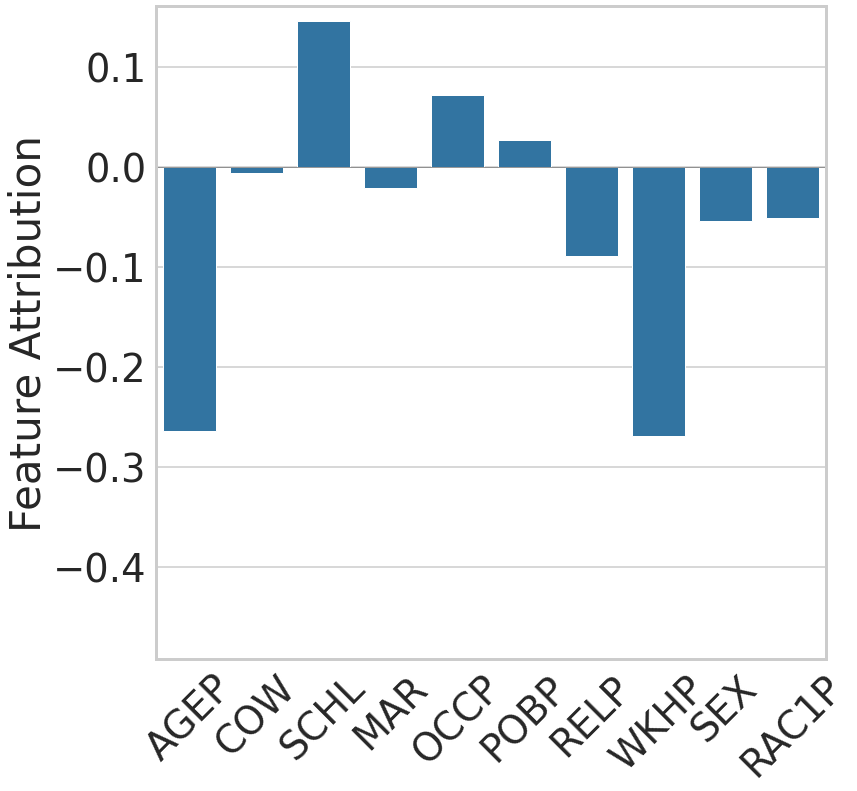

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


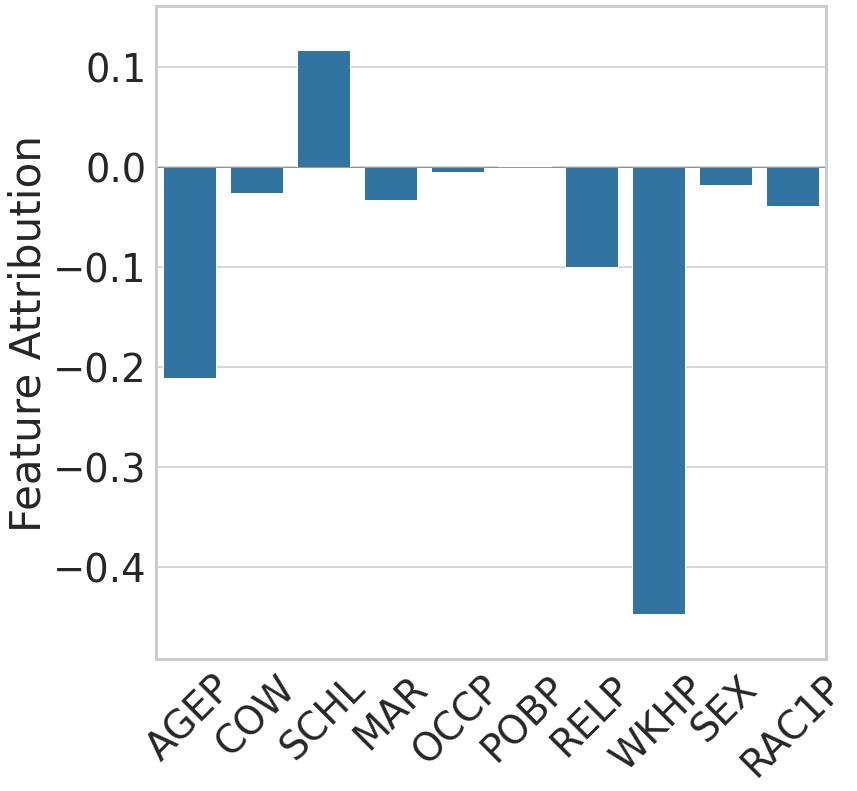

--------------------- Example 1 ----------------------
Predicted Probabilities:  [[0.9206303 0.0793697]]  Predicted Class:  0


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


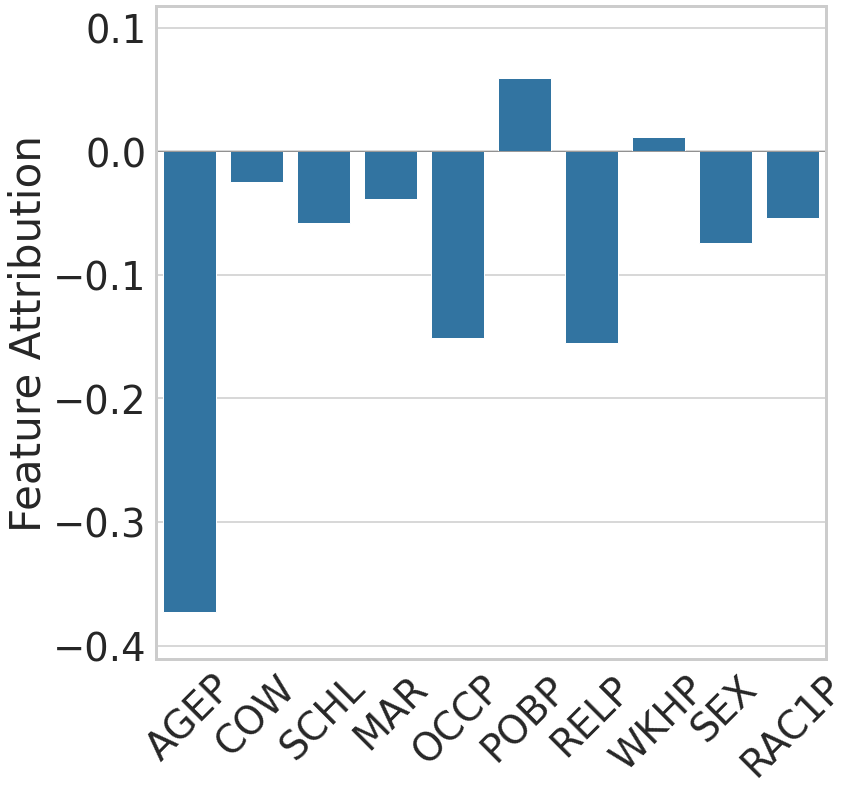

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


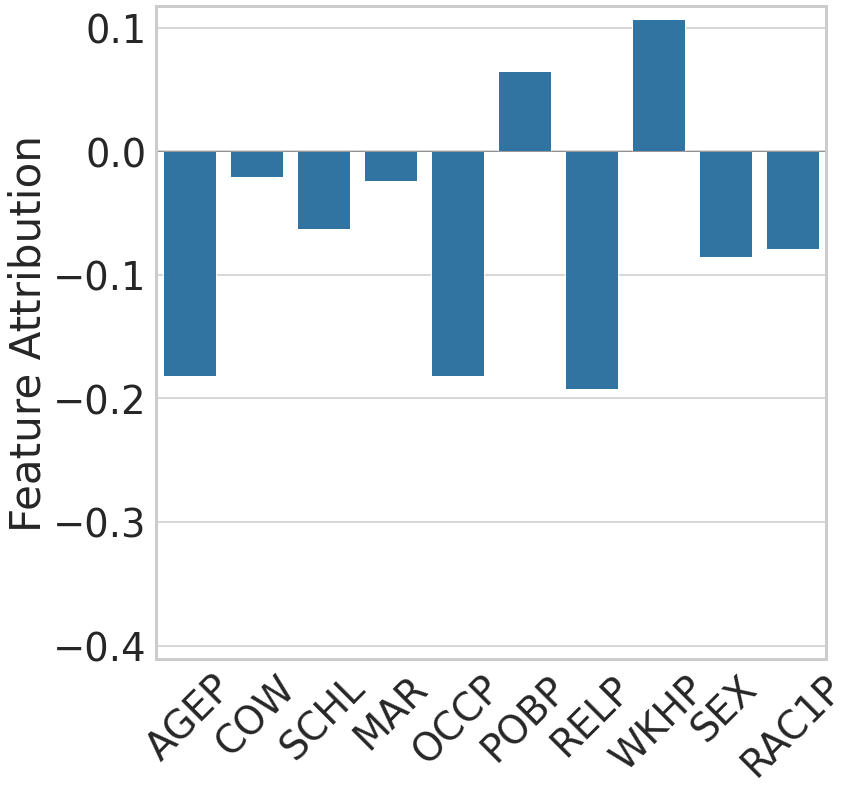

--------------------- Example 2 ----------------------
Predicted Probabilities:  [[0.9323199  0.06768014]]  Predicted Class:  0


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


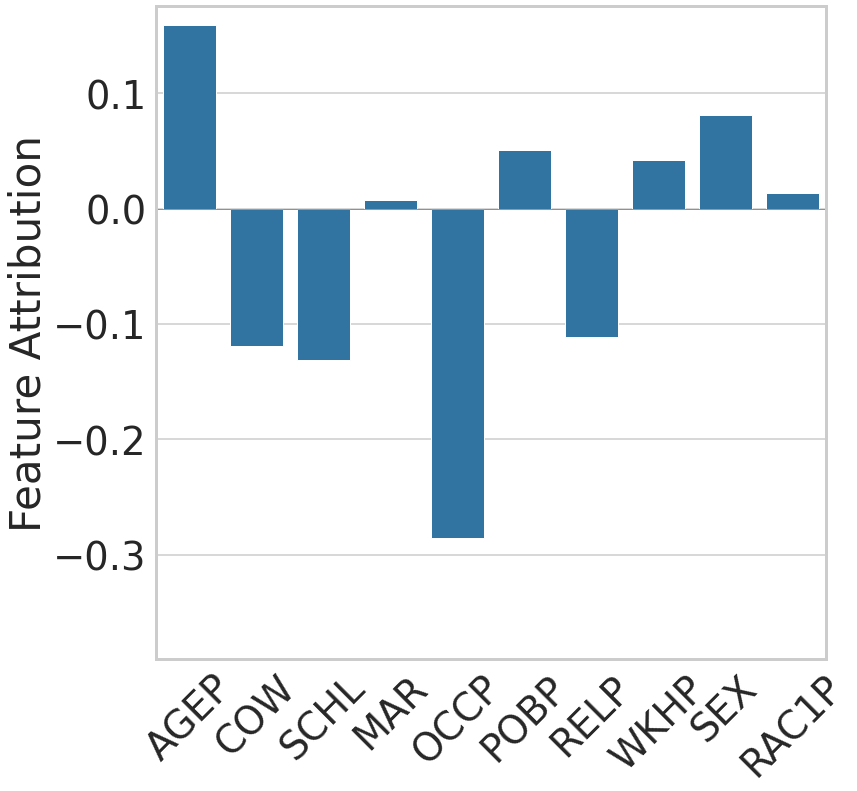

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


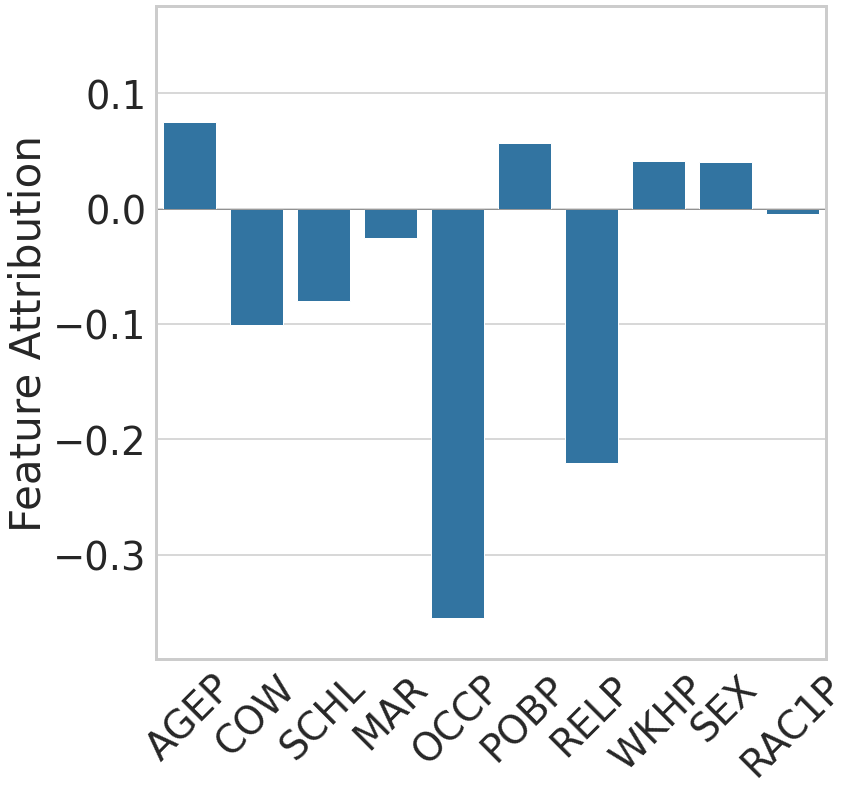

--------------------- Example 3 ----------------------
Predicted Probabilities:  [[0.1013763 0.8986237]]  Predicted Class:  1


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


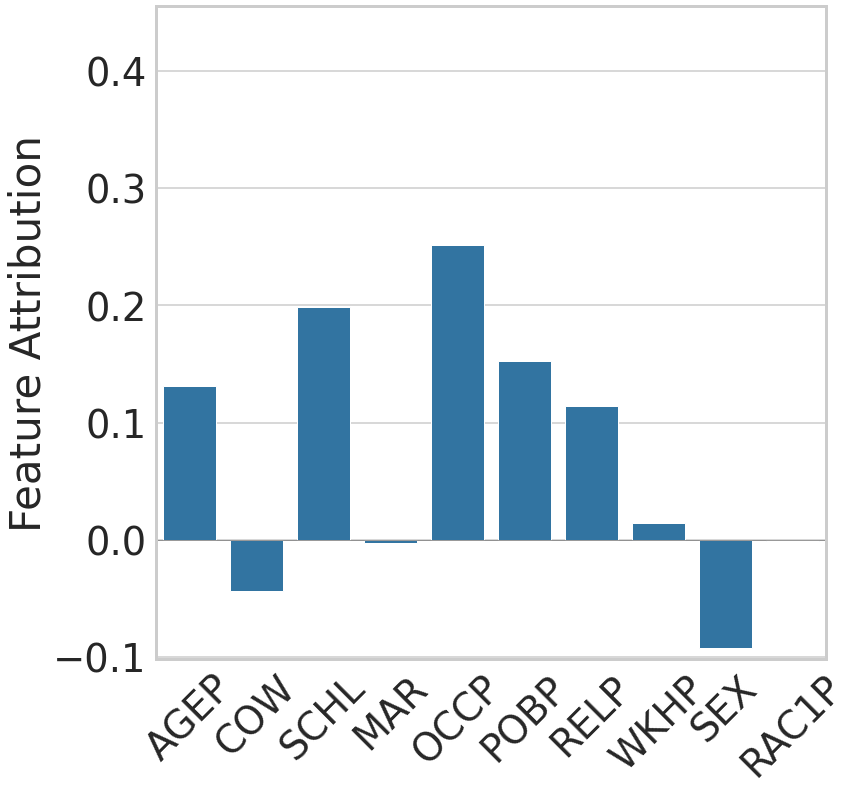

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


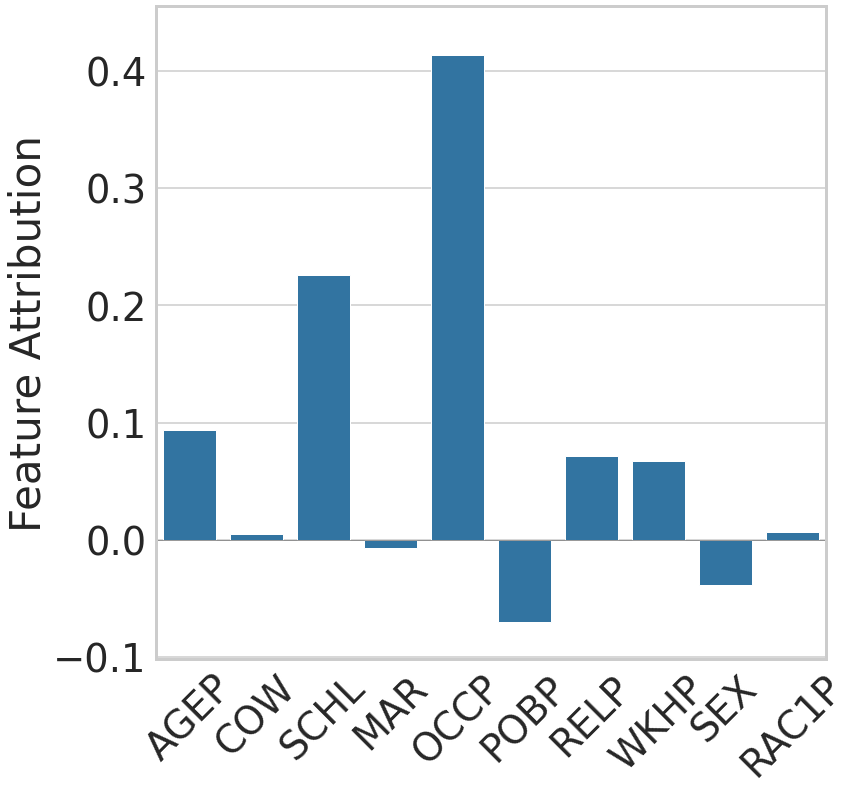

--------------------- Example 4 ----------------------
Predicted Probabilities:  [[0.96058017 0.03941984]]  Predicted Class:  0


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


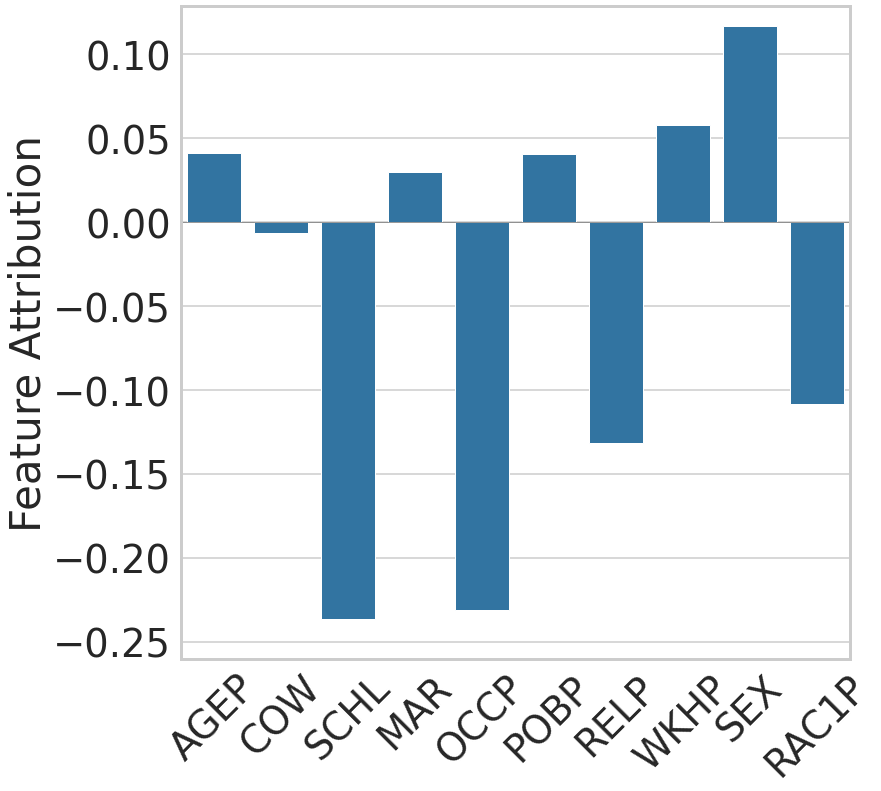

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


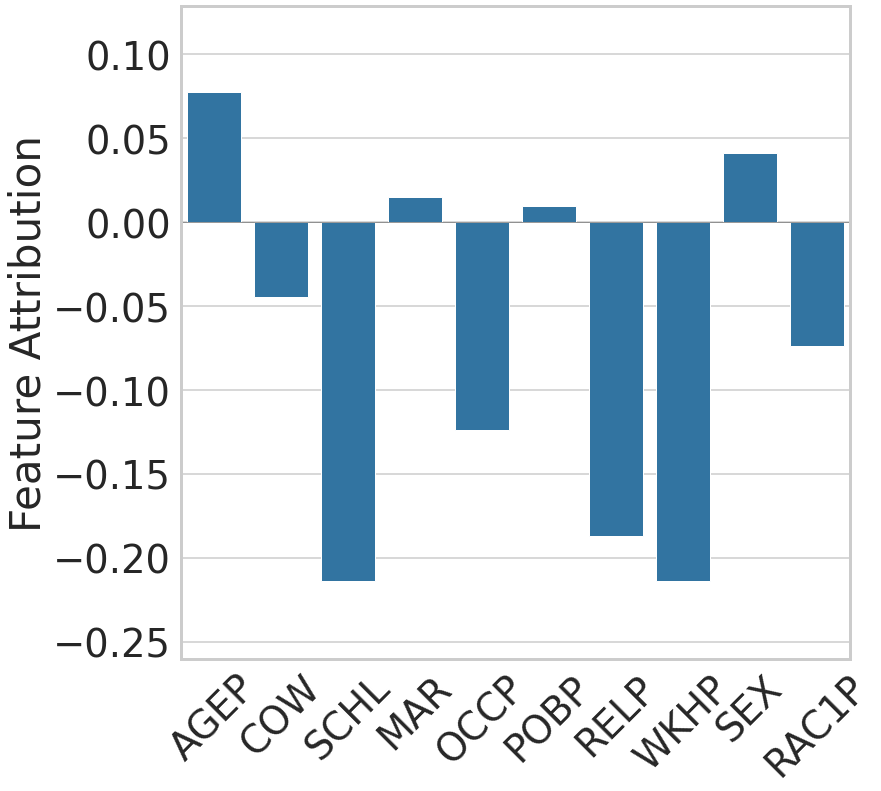

--------------------- Example 5 ----------------------
Predicted Probabilities:  [[0.6121626 0.3878374]]  Predicted Class:  0


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


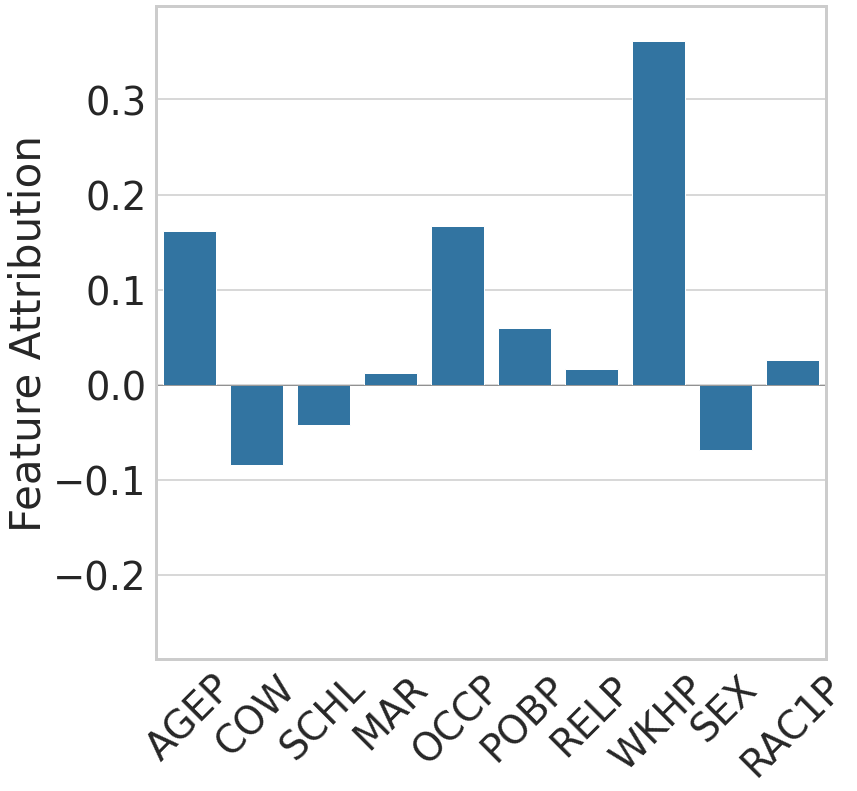

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


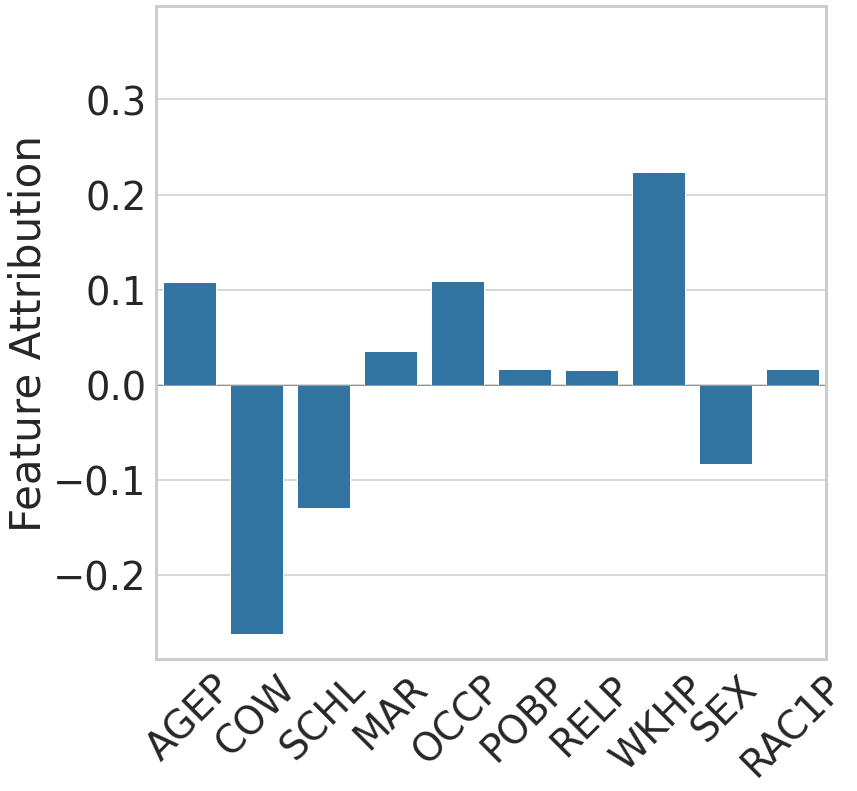

In [9]:
for i in range(6):
    x = X_test[i, :]
    print(f'--------------------- Example {i} ----------------------')
    probabilities = gbtree.predict_proba(x.reshape(1, -1))
    top_class = probabilities.argmax()
    print('Predicted Probabilities: ', probabilities, ' Predicted Class: ', top_class)
    
    # LIME
    exp = lime_explainer.explain_instance(x, gbtree.predict_proba, num_features=10)
    lime_attributions = futil.extract_lime_attributions(exp, ACSIncome.features)
    lime_attributions = lime_attributions / np.linalg.norm(lime_attributions, 1)
    
    # Shap
    shap_values = shap_explainer.shap_values(x.reshape(1, 10))
    shap_attributions = shap_values[0] / np.linalg.norm(shap_values[0], 1)

    # Plots
    ymin = 1.1*min(lime_attributions.min(), shap_attributions.min())
    ymax = 1.1*max(lime_attributions.max(), shap_attributions.max())

    futil.viz_feature_attributions(lime_attributions, ACSIncome.features, None, ylim=(ymin, ymax))
    plt.savefig(f'figures/folktables/{i}_lime.pdf', bbox_inches='tight', facecolor='white')
    plt.show()
    futil.viz_feature_attributions(shap_attributions, ACSIncome.features, None, ylim=(ymin, ymax))
    plt.savefig(f'figures/folktables/{i}_shap.pdf', bbox_inches='tight', facecolor='white')
    plt.show()